In [197]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch
from tqdm import tqdm
import pandas as pd

import networkx as nx
import torch_geometric.utils as pyg_utils

import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

from data_utils import *
from graph_vae.vae import GraphVAE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

include_hydrogen = False

prop_norm_df = create_or_load_property_norm_df()

# create dataset and dataloaders
dataset = create_qm9_mixture_vae_dataset(
    device=device, 
    include_hydrogen=include_hydrogen,
    refresh_data_cache=False,
    properties=None,
    prop_norm_df=prop_norm_df
)
train_dataset, val_dataset, _ = create_qm9_data_split(dataset=dataset)

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [198]:
train_batch = next(iter(train_loader))

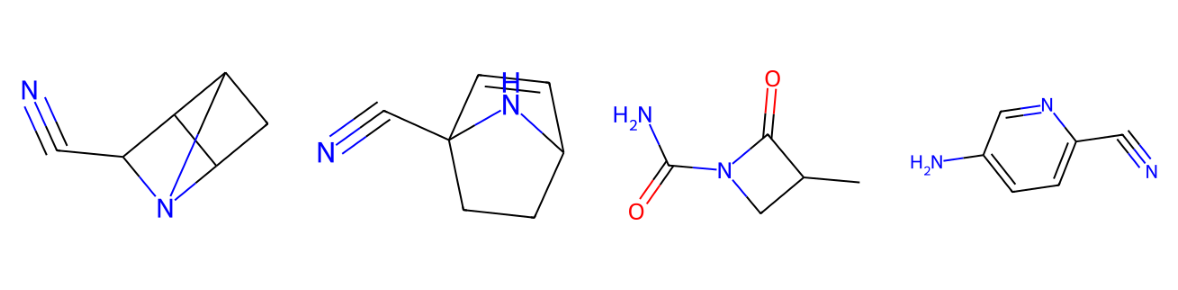

In [201]:
fig, axs = plt.subplots(1, batch_size, figsize=(batch_size * 3, 3))
if batch_size > 1:
    axs = axs.flatten()

for i in range(len(train_batch)):
    batch_mask = train_batch.batch == i
    
    graph = train_batch[i]
    mol = graph_to_mol(data=graph, includes_h=include_hydrogen, validate=False)
    if batch_size > 1:
        axis = axs[i]
    else:
        axis = axs
    axis.imshow(Draw.MolToImage(mol))
    axis.axis("off")

plt.tight_layout()
plt.show()

# Decoder

In [237]:
import itertools
from typing import Dict, Any

import torch
import torch.nn as nn
import torch.nn.functional as F


class MixtureModelDecoder(nn.Module):

    def __init__(self, hparams: Dict[str, Any]) -> None:
        super().__init__()

        num_clusters = hparams["num_clusters"]
        self.num_clusters = num_clusters
        latent_dim = hparams["latent_dim"]
        num_atom_types = hparams["num_atom_types"]
        num_bond_types = hparams["num_bond_types"] + 1  # +1 for non-existent bonds

        # model parameters
        self.eta_mu = nn.Parameter(torch.randn(1, num_clusters))
        self.eta_log_sigma = nn.Parameter(torch.randn(1, num_clusters))
        self.cluster_means = nn.Parameter(torch.randn(1, num_clusters, latent_dim))
        self.cluster_log_sigmas = nn.Parameter(torch.randn(1, num_clusters, latent_dim))
        self.atom_classifier = nn.Sequential(
            nn.Linear(latent_dim, num_atom_types),
            nn.Softmax(dim=1)
        )
        self.bond_matrix = nn.Parameter(torch.randn(1, num_bond_types, latent_dim, latent_dim))

        # TODO: anneal during training
        self.gumbel_softmax_temperature = 0.1

        # create edge indices of fully connected graph for all graph sizes up to 50
        self.edge_indices = []
        for N in range(2, 50):
            self.edge_indices.append(
                torch.tensor(list(itertools.combinations(range(N), 2)))
            )


    
    def sample(self, num_atoms: torch.Tensor, device: str) -> Data:
        eta = torch.randn(size=(num_atoms.size(0), self.num_clusters), device=device)
        return self.forward(eta, num_atoms)


    def forward(self, eta: torch.Tensor, num_atoms: torch.Tensor) -> Data:

        device = eta.device

        pi = F.softmax(eta, dim=1)
        pi = torch.repeat_interleave(pi, num_atoms, dim=0)
         
        # sample clusters using the gumbel-softmax reparameterization
        c = F.gumbel_softmax(logits=pi, tau=self.gumbel_softmax_temperature, hard=True).unsqueeze(-1)

        mu = torch.sum(self.cluster_means * c, dim=1)
        log_sigma = torch.sum(self.cluster_log_sigmas * c, dim=1)
        sigma = torch.exp(log_sigma)

        z = torch.randn_like(mu) * sigma + mu

        atom_types = self.atom_classifier(z)
        
        # create edge indices of fully connected graphs
        edge_index_list = []
        offsets = torch.cat([torch.tensor([0], device=device), torch.cumsum(num_atoms, dim=0)[:-1]])
        for i, N in enumerate(num_atoms):
            pairs = self.edge_indices[N - 2].to(device)
            pairs += offsets[i]
            edge_index_list.append(pairs)

        edge_index = torch.cat(edge_index_list, dim=0)

        # make bond matrix symmetric to ensure permuation invariance
        W = (self.bond_matrix + self.bond_matrix.transpose(2, 3)) * 0.5

        z_pairs = z[edge_index].unsqueeze(-2).unsqueeze(-1)
        edge_type_logits = z_pairs[:, 0].permute(dims=(0, 1, 3, 2)) @ W @ z_pairs[:, 1]
        edge_types = F.softmax(edge_type_logits, dim=1).squeeze()

        edge_index = edge_index.t().contiguous()

        batch = torch.repeat_interleave(torch.arange(len(num_atoms), device=device), num_atoms)
        return Data(x=atom_types, edge_index=edge_index, edge_attr=edge_types, batch=batch)


num_clusters = 16
hparams = {
    "num_clusters": num_clusters,
    "latent_dim": 2,
    "num_atom_types": dataset.num_node_features,
    "num_bond_types": dataset.num_edge_features,
}
print(hparams)

decoder_model = MixtureModelDecoder(hparams=hparams).to(device)

num_atoms = torch.tensor([3, 3], dtype=torch.int64, device=device)
data = decoder_model.sample(num_atoms, device)
data

{'num_clusters': 16, 'latent_dim': 2, 'num_atom_types': 4, 'num_bond_types': 4}


Data(x=[6, 4], edge_index=[2, 6], edge_attr=[6, 5], batch=[6])

In [238]:
def get_batch_item(batch_data: Data, i: int):
    node_mask = batch_data.batch == i

    offsets = torch.cumsum(torch.bincount(batch_data.batch), dim=0)

    edge_mask = (batch_data.edge_index[0] < offsets[i]) & (batch_data.edge_index[1] < offsets[i])
    if i > 0:
        edge_mask &= (batch_data.edge_index[0] >= offsets[i - 1]) & (batch_data.edge_index[1] >= offsets[i - 1])

    # remove non-existent edges
    edge_mask &= batch_data.edge_attr.argmax(dim=1) < 4
    edge_attr = batch_data.edge_attr[edge_mask][:,:-1]

    # adjust edge index based on batch index
    edge_index = batch_data.edge_index[:, edge_mask]
    if i > 0:
        edge_index -= offsets[i - 1]

    return Data(
        x=batch_data.x[node_mask],
        edge_index=edge_index,
        edge_attr=edge_attr
    )

get_batch_item(data, 1)

Data(x=[3, 4], edge_index=[2, 2], edge_attr=[2, 4])

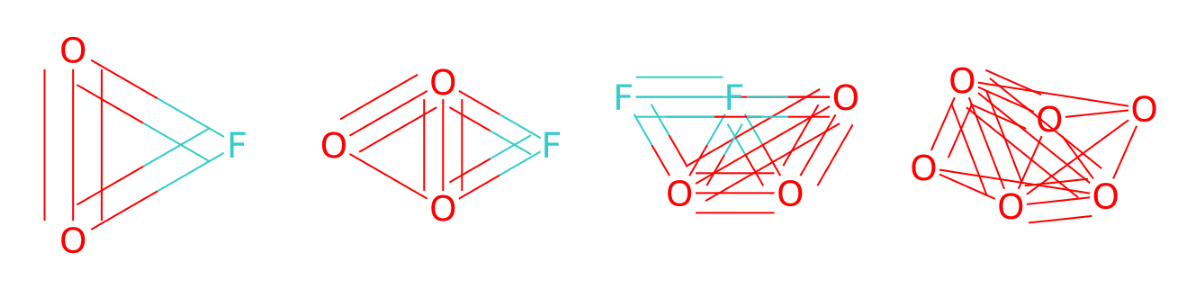

In [242]:
num_atoms = torch.tensor([3, 4, 5, 6], dtype=torch.int64, device=device)
data = decoder_model.sample(num_atoms, device)

num_molecules = len(num_atoms)

fig, axs = plt.subplots(1, num_molecules, figsize=(num_molecules * 3, 3))
if num_molecules > 1:
    axs = axs.flatten()

for i in range(num_molecules):
    graph = get_batch_item(data, i)
    mol = graph_to_mol(data=graph, includes_h=include_hydrogen, validate=False)
    if num_molecules > 1:
        axis = axs[i]
    else:
        axis = axs
    axis.imshow(Draw.MolToImage(mol))
    axis.axis("off")


plt.tight_layout()
plt.show()

# Encoder

In [ ]:
from torch_geometric.nn import BatchNorm
from graph_vae.encoder import ECCConv

class MixtureModelEncoder(nn.Module):

    def __init__(self, num_node_features: int, num_edge_features: int, channels: List[int]) -> None:
        super().__init__()

        self.latent_dim = hparams["latent_dim"]

        self.ecc_conv_1 = ECCConv(
            num_edge_features=hparams["num_edge_features"],
            in_channels=hparams["num_node_features"],
            out_channels=32
        )
        self.batch_norm_1 = BatchNorm(in_channels=32)
        self.act_1 = nn.PReLU()
        self.ecc_conv_2 = ECCConv(
            num_edge_features=hparams["num_edge_features"],
            in_channels=32,
            out_channels=64
        )
        self.batch_norm_2 = BatchNorm(in_channels=64)
        self.act_2 = nn.PReLU()
        self.ecc_conv_3 = ECCConv(
            num_edge_features=hparams["num_edge_features"],
            in_channels=64,
            out_channels=128
        )
        self.batch_norm_3 = BatchNorm(in_channels=128)
        self.relu_3 = nn.PReLU()

        #self.graph_pooling = GlobalGraphPooling(in_channels=128, out_channels=128)

        # output 2 time the size of the latent vector
        # one half contains mu and the other half log(sigma)
        #self.fc = nn.Linear(in_features=128, out_features=self.latent_dim * 2)


    def forward(self, data: Data) -> Tuple[torch.Tensor, torch.Tensor]:
        x, edge_index, batch, edge_attr = data.x, data.edge_index, data.batch, data.edge_attr

        x = self.ecc_conv_1(x, edge_index, edge_attr)
        x = self.batch_norm_1(x)
        x = self.act_1(x)
        x = self.ecc_conv_2(x, edge_index, edge_attr)
        x = self.batch_norm_2(x)
        x = self.act_2(x)
        x = self.ecc_conv_3(x, edge_index, edge_attr)
        x = self.batch_norm_3(x)
        x = self.relu_3(x)

        #x = self.graph_pooling(x, batch)

        #x = self.fc(x)

        #mu = x[:, :self.latent_dim]
        #log_sigma = x[:, self.latent_dim:]
        #return mu, log_sigma